<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/L1LossOnly_0.0005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       #transforms.RandomHorizontalFlip(0.1),
                                       #transforms.RandomResizedCrop(28),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
        ) # output_size = 16
       
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 16
      

        self.pool2 = nn.MaxPool2d(2,2) # output_size = 8
        
        # TRANSITION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
        ) # output_size = 8
  
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x) 
        x = self.convblock4(x)
        
        x = self.pool2(x)    
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 20, 28, 28]           1,800
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
           Dropout-7           [-1, 20, 28, 28]               0
         MaxPool2d-8           [-1, 20, 14, 14]               0
            Conv2d-9           [-1, 10, 16, 16]             200
           Conv2d-10           [-1, 20, 16, 16]           1,800
             ReLU-11           [-1, 20, 16, 16]               0
      BatchNorm2d-12           [-1, 20, 16, 16]              40
          Dropout-13           [-1, 20, 16, 16]               0
        MaxPool2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  LAMBDA =  0.0005

  criterion = nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    l1_reg_loss = 0
    for param in model.parameters():
      l1_reg_loss += torch.sum(abs(param))

    classify_loss = criterion(y_pred, target)

    #loss = F.nll_loss(y_pred, target)

    loss = classify_loss + LAMBDA * l1_reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:

def find_actual_pred_map(model, num=25):
  images=[]
  target_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d , t , p in zip(data, target, pred):
        if t!=p:
          d = d.cpu().numpy()
          t = t.cpu().numpy()
          p = p.cpu().numpy()
          d = (d*0.3081)+0.1307
          images.append(d)
          target_list.append(t)
          pred_list.append(p)
          count+=1
        if count == num:
          return images, target_list, pred_list

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

images, targ, pred = find_actual_pred_map(model, 25)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.44360142946243286 Batch_id=937 Accuracy=89.61: 100%|██████████| 938/938 [00:19<00:00, 47.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1005, Accuracy: 9712/10000 (97.12%)

EPOCH: 1


Loss=0.36596089601516724 Batch_id=937 Accuracy=96.83: 100%|██████████| 938/938 [00:19<00:00, 47.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9723/10000 (97.23%)

EPOCH: 2


Loss=0.2905504107475281 Batch_id=937 Accuracy=97.04: 100%|██████████| 938/938 [00:19<00:00, 47.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Loss=0.26064854860305786 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:19<00:00, 47.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9795/10000 (97.95%)

EPOCH: 4


Loss=0.3838905096054077 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:19<00:00, 47.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.31630170345306396 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9720/10000 (97.20%)

EPOCH: 6


Loss=0.32003724575042725 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:19<00:00, 47.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.23136577010154724 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:19<00:00, 48.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 9820/10000 (98.20%)

EPOCH: 8


Loss=0.3114165663719177 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:19<00:00, 47.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9814/10000 (98.14%)

EPOCH: 9


Loss=0.21520790457725525 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9860/10000 (98.60%)

EPOCH: 10


Loss=0.31488123536109924 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:19<00:00, 47.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.43921250104904175 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:19<00:00, 48.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0832, Accuracy: 9750/10000 (97.50%)

EPOCH: 12


Loss=0.24441759288311005 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9789/10000 (97.89%)

EPOCH: 13


Loss=0.34158992767333984 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9854/10000 (98.54%)

EPOCH: 14


Loss=0.22656939923763275 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 47.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9875/10000 (98.75%)

EPOCH: 15


Loss=0.21853947639465332 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:19<00:00, 48.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9756/10000 (97.56%)

EPOCH: 16


Loss=0.2049943506717682 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9856/10000 (98.56%)

EPOCH: 17


Loss=0.34454596042633057 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:19<00:00, 47.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9781/10000 (97.81%)

EPOCH: 18


Loss=0.33291587233543396 Batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [00:19<00:00, 47.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9791/10000 (97.91%)

EPOCH: 19


Loss=0.17833895981311798 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 47.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9700/10000 (97.00%)

EPOCH: 20


Loss=0.346838116645813 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:19<00:00, 47.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9825/10000 (98.25%)

EPOCH: 21


Loss=0.3057073950767517 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:19<00:00, 48.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0815, Accuracy: 9753/10000 (97.53%)

EPOCH: 22


Loss=0.5324644446372986 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:19<00:00, 47.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9865/10000 (98.65%)

EPOCH: 23


Loss=0.2198614776134491 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:19<00:00, 48.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9811/10000 (98.11%)

EPOCH: 24


Loss=0.21194244921207428 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:19<00:00, 48.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9849/10000 (98.49%)

EPOCH: 25


Loss=0.3233458697795868 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:19<00:00, 47.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9855/10000 (98.55%)

EPOCH: 26


Loss=0.2106996774673462 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:19<00:00, 48.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9845/10000 (98.45%)

EPOCH: 27


Loss=0.1819777637720108 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:19<00:00, 48.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9858/10000 (98.58%)

EPOCH: 28


Loss=0.2054004669189453 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:19<00:00, 47.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9856/10000 (98.56%)

EPOCH: 29


Loss=0.18678408861160278 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:19<00:00, 47.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9862/10000 (98.62%)

EPOCH: 30


Loss=0.22482140362262726 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:19<00:00, 48.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9854/10000 (98.54%)

EPOCH: 31


Loss=0.17797739803791046 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9838/10000 (98.38%)

EPOCH: 32


Loss=0.19342996180057526 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 48.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9789/10000 (97.89%)

EPOCH: 33


Loss=0.1783432960510254 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9885/10000 (98.85%)

EPOCH: 34


Loss=0.18316365778446198 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:19<00:00, 47.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9893/10000 (98.93%)

EPOCH: 35


Loss=0.2579527199268341 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:19<00:00, 48.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9853/10000 (98.53%)

EPOCH: 36


Loss=0.31862202286720276 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:19<00:00, 47.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 37


Loss=0.24545595049858093 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:19<00:00, 47.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9798/10000 (97.98%)

EPOCH: 38


Loss=0.17371992766857147 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:19<00:00, 55.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Accuracy: 9736/10000 (97.36%)

EPOCH: 39


Loss=0.26570579409599304 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:19<00:00, 47.94it/s]



Test set: Average loss: 0.0449, Accuracy: 9865/10000 (98.65%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

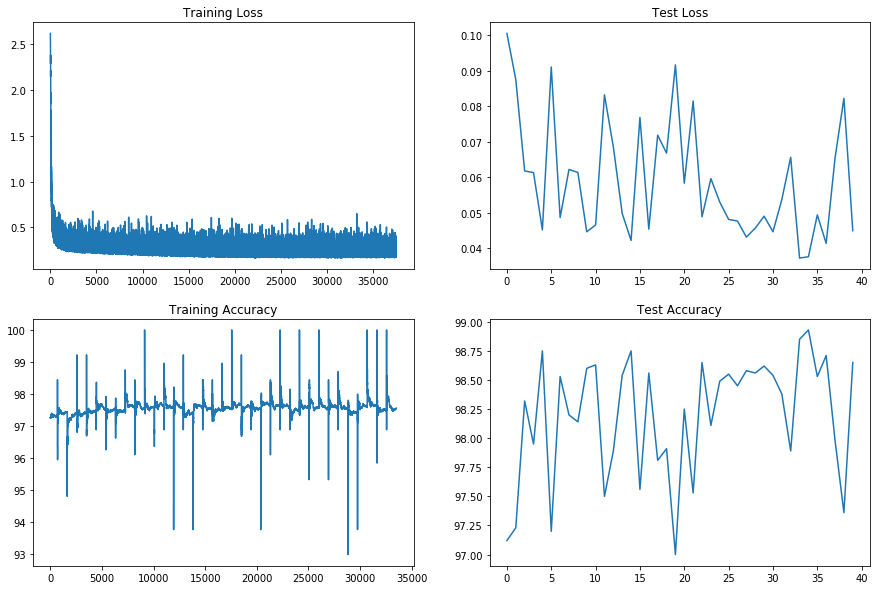

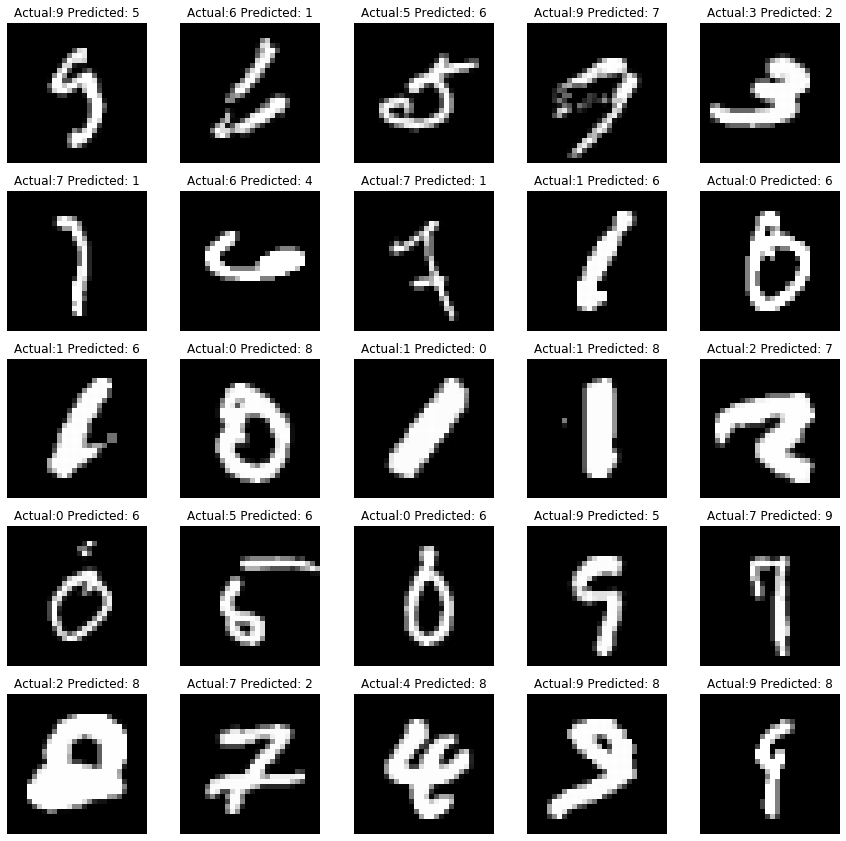

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

fig = plt.figure(figsize=(15, ((25//5)+1)*3))

for i in range(0, 25):
  ax=fig.add_subplot((25//5)+1, 5, i+1)
  ax.imshow(np.rollaxis(images[i], 0, 3).squeeze(), cmap='gray')
  ax.axis('off')
  ax.set_title("Actual:"+str(targ[i])+" Predicted: "+str(pred[i]))

plt.savefig('L1_REG.png')
plt.show()



In [0]:
TARGET: Improve train and test accuracy to reach desired targets within 15 epoch

RESULT: Achieved the target , got 99.45 % test accuracy in EPOCH 13 and there after results remained closer to this accuracy in rest of the epochs.Also the train accuracy slightly improved compared to the previous one.

         Total Params: 9,482
         Best train accuracy: 99.00
         Best test accuracy:  99.45

ANALYSIS: Did not apply drop out in Conv5 layer.Also adding second max pooling earlier has increased the RF to 56